In [66]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [67]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [68]:
! rm -rf StarWars.csv
! wget https://raw.githubusercontent.com/fivethirtyeight/data/master/star-wars-survey/StarWars.csv

--2017-01-22 19:02:57--  https://raw.githubusercontent.com/fivethirtyeight/data/master/star-wars-survey/StarWars.csv
Resolving raw.githubusercontent.com... 151.101.112.133
Connecting to raw.githubusercontent.com|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531696 (519K) [text/plain]
Saving to: 'StarWars.csv'

StarWars.csv        100%[===================>] 519.23K  2.54MB/s    in 0.2s    

2017-01-22 19:02:58 (2.54 MB/s) - 'StarWars.csv' saved [531696/531696]



In [69]:
data_file = 'StarWars.csv'
raw_df = pd.read_csv(data_file)

In [70]:
original_header = raw_df.columns
line_1 = raw_df.iloc[0]

### Cleaning up the data

1. We need to drop lines that don't carry any meaningful value. (I'm using a proxy here, I've concluded that if the answer for "Do you consider yourself to be a fan of the Star Wars film franchise?" is empty (or Nan), then all the following columns will be empty too. These lines would introduce bias and we should work hard to imput missing data in a reasonable way, so it makes more sense to simply throw them away. )
2. String values need to be encoded as integers, otherwise scikit learn models won't be able to handle them. 
3. We must pay attention that ordinal categories are encoded properly

In [71]:
sw_df = raw_df[raw_df['Do you consider yourself to be a fan of the Star Wars film franchise?'].notnull() ]
columns_needed = []

sw_df = sw_df[sw_df.RespondentID.notnull()]
sw_df['ep1_seen'] = sw_df['Which of the following Star Wars films have you seen? Please select all that apply.'].map(lambda x: pd.notnull(x))
columns_needed.append('ep1_seen')
for i in range(4, 9):
    episode_cnt = i - 2
    orig_col = 'Unnamed: {}'.format(i)
    new_col = 'ep{}_seen'.format(episode_cnt) 
    sw_df[new_col] = sw_df[orig_col].map(lambda x: pd.notnull(x))
    columns_needed.append(new_col)
    

for ix in range(9, 15):
    orig_col = original_header[ix]
    new_col = 'favorite_{}'.format(ix-8)
    sw_df[new_col] = sw_df[orig_col].map(lambda x: x if pd.notnull(x) else 0)
    columns_needed.append(new_col)

rating = {'Very unfavorably': 0, 
          'Somewhat unfavorably': 1,
          'Unfamiliar (N/A)': 2,
          'Neither favorably nor unfavorably (neutral)': 3,
          'Somewhat favorably': 4,
          'Very favorably': 5
         } 
for ix in range(15, 29):
    orig_col = original_header[ix]
    new_col = line_1[ix]
    sw_df[new_col] = sw_df[orig_col].map(lambda x: rating.get(x, 2))
    columns_needed.append(new_col)

yes_no = {'Yes': True, 'No': False}
sw_df['fan'] = sw_df['Do you consider yourself to be a fan of the Star Wars film franchise?'].map(lambda x: yes_no.get(x, False))
columns_needed.append('fan')
sw_df['seen_any'] = sw_df['Have you seen any of the 6 films in the Star Wars franchise?'].map(lambda x: yes_no.get(x, False))
columns_needed.append('seen_any')
sw_df['universe'] = sw_df['Are you familiar with the Expanded Universe?'].map(lambda x: yes_no.get(x, False))
columns_needed.append('universe')
sw_df['fan_universe'] = sw_df['Do you consider yourself to be a fan of the Expanded Universe?\x8c\xe6'].map(lambda x: yes_no.get(x, False))
columns_needed.append('fan_universe')
sw_df['trekkie'] = sw_df['Do you consider yourself to be a fan of the Star Trek franchise?'].map(lambda x: yes_no.get(x, False))
columns_needed.append('trekkie')


education = {'Less than high school degree':1, 
             'High school degree': 2, 
             'Some college or Associate degree': 3,
             'Bachelor degree': 4,
             'Graduate degree': 5
            }
sw_df['education'] = sw_df['Education'].map(lambda x: education.get(x, 0))
columns_needed.append('education')

age = {'18-29': 18,
       '30-44': 30,
       '45-60': 45,
       '> 60': 60
      }
sw_df['age'] = sw_df['Age'].map(lambda x: age.get(x, 0))
columns_needed.append('age')

income = { '$0 - $24,999': 1, 
          '$25,000 - $49,999': 25,
          '$50,000 - $99,999': 50,
          '$100,000 - $149,999': 100,
         '$150,000+': 150}
sw_df['income'] = sw_df['Household Income'].map(lambda x: income.get(x, 0))
columns_needed.append('income')

sw_df['likes_jarjar'] = sw_df['Jar Jar Binks'].map(lambda x: x==5)
columns_needed.append('likes_jarjar')

In [72]:
df = sw_df[sw_df.RespondentID.notnull()][columns_needed]

### Who likes Jar Jar?

This is the main question here, so that will be out target variable.
Let's transform the 5-grade scale to a yes/no question: if someone find Jar Jar Binks Very favorably, then they like Jar Jar, otherwise not.

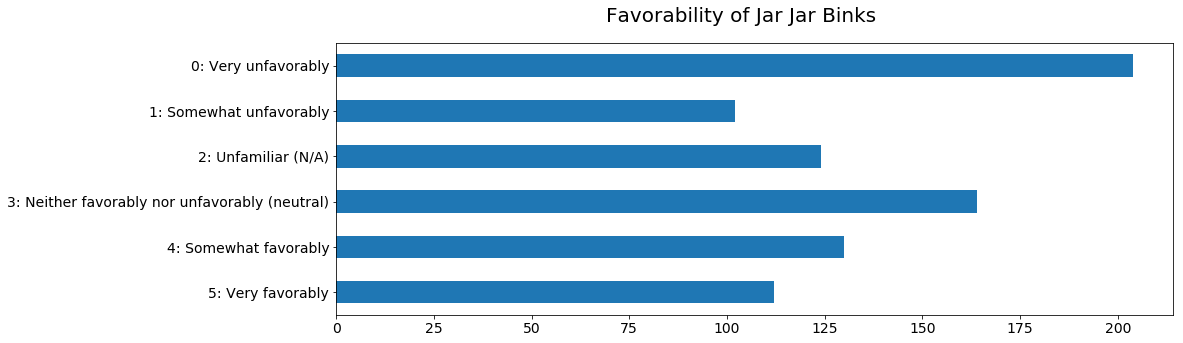

In [73]:
rating_inverse = {}
for k, v in rating.iteritems():
    rating_inverse[v] = k

jar_jar_ratings = sw_df['Jar Jar Binks'].map(lambda x: str(x) + ": " + rating_inverse[x]).value_counts().sort_index(ascending=False)
jar_jar_ratings.plot(kind='barh', fontsize=14, figsize=(15,5))
plt.suptitle('Favorability of Jar Jar Binks', fontsize=20)

In [74]:
x = jar_jar_ratings.to_frame()
x.div(x.sum(), axis=1)*100

,Jar Jar Binks
5: Very favorably,13.397129
4: Somewhat favorably,15.550239
3: Neither favorably nor unfavorably (neutral),19.617225
2: Unfamiliar (N/A),14.832536
1: Somewhat unfavorably,12.200957
0: Very unfavorably,24.401914


## Predicting Jar Jar's favorability

In [75]:
dependent = list(df.columns.difference(['Jar Jar Binks', 'likes_jarjar']))
target = 'likes_jarjar'

### Decision tree

Let's build an easy-to-interpret model!

In [76]:
from sklearn.model_selection import train_test_split
from sklearn import tree

train_df, test_df = train_test_split(df, test_size = 0.4, random_state=1977)
X = np.array(train_df[dependent])
Y = np.array(train_df[target])
test_x = np.array(test_df[dependent])
test_y = np.array(test_df[target])

clf = tree.DecisionTreeClassifier(min_samples_split=5,
                                  min_samples_leaf = 3,
                                  max_depth=4,
                                  random_state=1977,
                                  criterion='entropy')
clf = clf.fit(X, Y)

clf.score(test_x, test_y)

0.86865671641791042

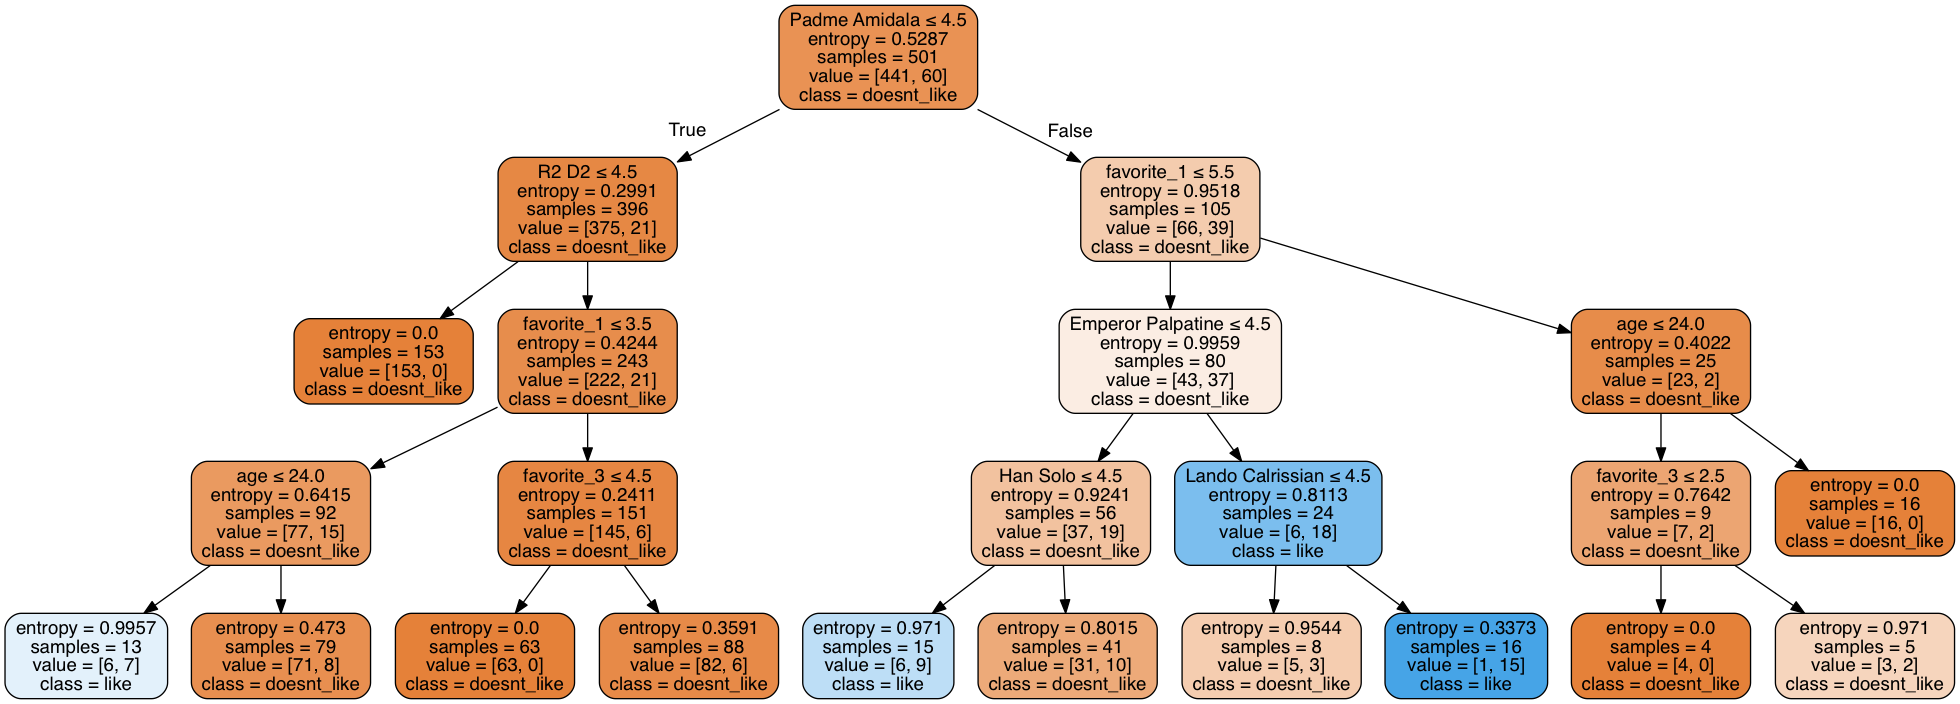

In [77]:
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=dependent,  
                         class_names=['doesnt_like','like'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

## Comparing model performance using cross validation

In [78]:
from sklearn.model_selection import cross_val_score

In [79]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
scores = cross_val_score(nb_clf, df[dependent], df[target], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy: 0.71 (+/- 0.04)


In [80]:
from sklearn.ensemble import RandomForestClassifier
dt_clf = tree.DecisionTreeClassifier(min_samples_split=5,
                                     min_samples_leaf = 3,
                                     max_depth=4,
                                     random_state=1977,
                                     criterion='entropy')
dt_scores = cross_val_score(dt_clf, df[dependent], df[target], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (dt_scores.mean(), dt_scores.std() * 2))

Accuracy: 0.87 (+/- 0.04)


In [81]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=20,
                                min_samples_split=5,
                                min_samples_leaf = 3,
                                max_depth=4,
                                random_state=1977, 
                                criterion='entropy')
rf_scores = cross_val_score(rf_clf, df[dependent], df[target], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (rf_scores.mean(), rf_scores.std() * 2))

Accuracy: 0.88 (+/- 0.02)
